1. Environment Setup
Install -> langgraph langchain langchain-groq tavily-python python-dotenv

Create a .env file for your API keys:

GROQ_API_KEY=your_groq_api_key
TAVILY_API_KEY=your_tavily_api_key

In [1]:
# 2. Initialize LLM and Tools

from langchain_groq import ChatGroq
from langchain_community.tools.tavily_search import TavilySearchResults
from dotenv import load_dotenv
import time
from groq import RateLimitError

In [2]:
load_dotenv()

# Initialize LLM
llm = ChatGroq(
    model="openai/gpt-oss-120b",
    temperature=0
)

validation_llm = ChatGroq(
    model="moonshotai/kimi-k2-instruct",
    temperature=0
)

# Initialize Search Tool
search_tool = TavilySearchResults(max_results=3)

C:\Users\HP\AppData\Local\Temp\ipykernel_340\2015665932.py:15: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search_tool = TavilySearchResults(max_results=3)


In [3]:
# 3. Define Agent State

from typing import TypedDict, List, Annotated
import operator

class ResearchState(TypedDict):
    question: str
    search_results: List[str]
    drafted_content: str
    refined_answer: str
    follow_up_questions: List[str]
    research_depth: int
    max_depth: int
    validation_score: float  # Optional for quality assessment
    validation_feedback: str  # Optional for quality assessment
    needs_more_research: bool
    

In [10]:
# Helper function for LLM requests with retry
def make_llm_request_with_retry(prompt, max_retries=3, specific_llm=None):
    # Use the provided LLM or default to the main LLM
    target_llm = specific_llm if specific_llm is not None else llm

    for attempt in range(max_retries):
        try:
            response = target_llm.invoke(prompt)
            return response
        except Exception as e:
            if "rate_limit" in str(e).lower() or "413" in str(e) or attempt < max_retries - 1:
                wait_time = 2 ** attempt  # Exponential backoff
                print(f"API limit exceeded. Waiting {wait_time} seconds before retry...")
                time.sleep(wait_time)
            else:
                raise e

In [5]:
# Helper function to summarize content
def summarize_content(content: str, max_length: int = 500) -> str:
    if len(content) <= max_length:
        return content
    
    prompt = f"""Summarize this content in {max_length} characters or less:
    
    {content}
    
    Summary:"""
    
    try:
        response = make_llm_request_with_retry(prompt)
        return response.content[:max_length]
    except:
        return content[:max_length] + "..."

In [11]:
# 4. Create Graph Nodes

from langgraph.graph import StateGraph, END

# Define graph builder
builder = StateGraph(ResearchState)

# Node 1: Research - Search the web
def research_node(state: ResearchState):
    results = search_tool.invoke({"query": state["question"]})
    summarized_results = [summarize_content(result["content"]) for result in results]
    return {"search_results": summarized_results}

# Node 2: Draft - Initial content generation
def draft_node(state: ResearchState):
    context = "\n\n".join(state["search_results"])
    
    # Truncate context if too long
    if len(context) > 3000:
        context = context[:3000] + "..."
    
    prompt = f"""Research and answer: {state['question']}
    
    Context:
    {context}
    
    Provide a comprehensive but concise answer:"""
    
    response = make_llm_request_with_retry(prompt)
    return {"drafted_content": response.content}

# Node 3: Refine - Improve the answer
def refine_node(state: ResearchState):
    # Truncate content if too long
    content = state["drafted_content"]
    if len(content) > 2000:
        content = content[:2000] + "..."
    
    prompt = f"""Refine this answer: {content}
    
    Ensure it's:
    1. Well-structured
    2. Contains citations
    3. Addresses all aspects of: {state['question']}
    
    Improved version:"""
    
    response = make_llm_request_with_retry(prompt)
    return {"refined_answer": response.content}

def generate_follow_ups_node(state: ResearchState):
    if state["research_depth"] >= state["max_depth"]:
        return {"follow_up_questions": []}
    
    # Truncate content if too long
    content = state["drafted_content"]
    if len(content) > 1500:
        content = content[:1500] + "..."
    
    prompt = f"""Based on the current research findings, generate 2-3 specific follow-up questions 
    that would help provide a more comprehensive answer to: {state['question']}
    
    Current research:
    {content}
    
    Generate specific, answerable follow-up questions:"""
    
    response = make_llm_request_with_retry(prompt)
    
    # Parse the response to extract questions
    questions = []
    for line in response.content.split('\n'):
        if line.strip() and any(char.isdigit() or char in ['-', '*'] for char in line[:3]):
            questions.append(line.split('.', 1)[-1].strip())
    
    return {"follow_up_questions": questions[:2]}  # Limit to 2 questions

def research_follow_ups_node(state: ResearchState):
    if not state["follow_up_questions"] or state["research_depth"] >= state["max_depth"]:
        return {"search_results": state["search_results"]}
    
    all_results = state["search_results"].copy()
    
    for question in state["follow_up_questions"]:
        results = search_tool.invoke({"query": question})
        for result in results:
            all_results.append(summarize_content(result["content"]))
    
    return {
        "search_results": all_results,
        "research_depth": state["research_depth"] + 1
    }


# New validation node
def validation_node(state: ResearchState):
    # Skip validation if we've already done it
    if state.get("validation_score", 0) > 0.6:  # Good enough score
        return {"needs_more_research": False}
    
    prompt = f"""Evaluate the quality of this research answer for the question: {state['question']}
    
    Answer to evaluate:
    {state['refined_answer']}
    
    Please evaluate based on these criteria:
    1. Completeness (does it address all aspects of the question?)
    2. Accuracy (is the information factually correct?)
    3. Depth (does it provide sufficient detail?)
    4. Structure (is it well-organized?)
    5. Citation quality (are sources properly referenced?)
    
    Provide:
    - A score from 0.0 to 1.0
    - Specific feedback on what could be improved
    - A boolean indicating if more research is needed
    
    Format your response as:
    Score: [0.0-1.0]
    Feedback: [your feedback]
    More Research Needed: [true/false]"""
    try:
        response = make_llm_request_with_retry(prompt, specific_llm=validation_llm)
        content = response.content

        # Parse the response
        score = 0.5  # Default
        feedback = "No specific feedback provided"
        needs_more_research = False
        
        # Extract score
        if "Score:" in content:
            try:
                score_str = content.split("Score:")[1].split("\n")[0].strip()
                score = float(score_str)
            except:
                pass

        # Extract feedback
        if "Feedback:" in content:
            feedback = content.split("Feedback:")[1].split("More Research Needed:")[0].strip()

        # Extract research recommendation
        if "More Research Needed:" in content:
            research_str = content.split("More Research Needed:")[1].strip().lower()
            needs_more_research = "true" in research_str or "yes" in research_str
        
        return {
            "validation_score": score,
            "validation_feedback": feedback,
            "needs_more_research": needs_more_research and state["research_depth"] < state["max_depth"]
        }
    except Exception as e:
        print(f"Validation error: {e}")
        return {
            "validation_score": 0.5,
            "validation_feedback": f"Validation failed: {str(e)}",
            "needs_more_research": False
        }
    
# New research improvement node
def improve_research_node(state: ResearchState):
    if not state["needs_more_research"]:
        return {"follow_up_questions": []}
    
    prompt = f"""Based on this validation feedback, generate specific follow-up research questions:
    
    Original question: {state['question']}
    Current answer: {state['refined_answer']}
    Validation feedback: {state['validation_feedback']}
    
    Generate 2-3 specific research questions that would address the validation feedback:"""

    response = make_llm_request_with_retry(prompt)

    # Parse the response to extract questions
    questions = []
    for line in response.content.split('\n'):
        if line.strip() and any(char.isdigit() or char in ['-', '*'] for char in line[:3]):
            questions.append(line.split('.', 1)[-1].strip())
    
    return {"follow_up_questions": questions[:2]}  # Limit to 2 questions
        

# Add nodes to graph
builder.add_node("research", research_node)
builder.add_node("draft", draft_node)
builder.add_node("refine", refine_node)
builder.add_node("generate_follow_ups", generate_follow_ups_node)
builder.add_node("research_follow_ups", research_follow_ups_node)
builder.add_node("validation", validation_node)
builder.add_node("improve_research", improve_research_node)


In [12]:
# 5. Define Graph Structure

# Set entry point
builder.set_entry_point("research")

# Create edges
builder.add_edge("research", "draft")
builder.add_edge("draft", "generate_follow_ups")

def should_continue_research(state: ResearchState):
    if state["follow_up_questions"] and state["research_depth"] < state["max_depth"]:
        return "research_follow_ups"
    return "refine"

builder.add_conditional_edges(
    "generate_follow_ups",
    should_continue_research,
    {
        "research_follow_ups": "research_follow_ups",
        "refine": "refine"
    }
)

builder.add_edge("research_follow_ups", "draft")
builder.add_edge("refine", "validation")

# Conditional edge for validation
def should_improve_research(state: ResearchState):
    if state["needs_more_research"]:
        return "improve_research"
    return END

builder.add_conditional_edges(
    "validation",
    should_improve_research,
    {
        "improve_research": "improve_research",
        END: END
    }
)

builder.add_edge("improve_research", "research_follow_ups")

# Compile graph
research_graph = builder.compile()

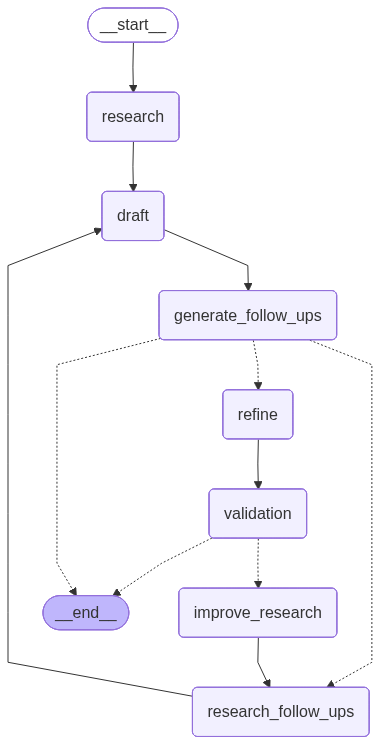

In [13]:
research_graph

In [14]:
# 6. Execute the Agent

# Run the graph
final_state = research_graph.invoke({
    "question": "Explain quantum computing breakthroughs in 2024",
    "search_results": [],
    "drafted_content": "",
    "refined_answer": "",
    "follow_up_questions": [],
    "research_depth": 0,
    "max_depth": 2,
    "validation_score": 0.0,
    "validation_feedback": "",
    "needs_more_research": False
})

print("Final refined answer:")
print(final_state["refined_answer"])
print("\nValidation Score:", final_state["validation_score"])
print("Validation Feedback:", final_state["validation_feedback"])

Final refined answer:
**Quantum Computing Break‑throughs in 2024 – A Structured Overview**  

*Prepared Oct 2024. All data are taken from peer‑reviewed papers, corporate road‑maps, and major conference proceedings published between Jan 2024 – Aug 2024.*  

---

## 1. Executive Summary  

| Aspect | 2024 Milestone | Why it matters | Readiness (Q‑CRL\*) |
|--------|----------------|----------------|----------------------|
| **Hardware scale** | First > 400‑qubit superconducting chip (IBM Condor‑1) and 56‑qubit silicon‑spin processor (Intel “Horse‑Power”) | Pushes the *quantum volume* frontier; enables small‑scale fault‑tolerant primitives | 5 (Condor‑1) – 4 (Spin) |
| **Logical‑qubit performance** | Surface‑code logical qubit with **d = 7** (error ≈ 10⁻⁴) on superconductors; **d = 9** logical qubit on trapped‑ion (error ≈ 5×10⁻⁵) | First logical qubits that meet the “break‑even” criterion for useful algorithms | 5 (Superconducting, Trapped‑Ion) |
| **Error‑correction demonstrations** | M